In [33]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import seaborn as sns
import time

In [57]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import joblib

In [3]:
path = '../data/data.csv'
df = pd.read_csv(path)
df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169909 entries, 0 to 169908
Data columns (total 19 columns):
acousticness        169909 non-null float64
artists             169909 non-null object
danceability        169909 non-null float64
duration_ms         169909 non-null int64
energy              169909 non-null float64
explicit            169909 non-null int64
id                  169909 non-null object
instrumentalness    169909 non-null float64
key                 169909 non-null int64
liveness            169909 non-null float64
loudness            169909 non-null float64
mode                169909 non-null int64
name                169909 non-null object
popularity          169909 non-null int64
release_date        169909 non-null object
speechiness         169909 non-null float64
tempo               169909 non-null float64
valence             169909 non-null float64
year                169909 non-null int64
dtypes: float64(9), int64(6), object(4)
memory usage: 24.6+ MB


# Data Cleaning

Features Selection
Looking closely at the features, there are some features to consider whether to include in the final model or not:

id: id is unique for each track, therfore cannot assist a model and will be dropped.

name: There are 132,940 unique values. In our opinion, this is a problematic categorical feature to insert in a model, and will be dropped.

artists: there are 33,375 unique features. Since we enticipate the artist will influence the popularity of the track, this feature will remain and be handled seperatley.

release_date: The 'year' feature is a derivative to the 'release_date' feature, therfore one of them should be excluded. Since the release date contains rows with full date and others with year only, the release_date will be dropped.

In [5]:
df = df.drop(labels=['id', 'name', 'release_date'], axis=1)
df.shape

(169909, 16)

In [6]:
# Cleaning duplicated data
print(df.duplicated().sum(),'duplicated data in the current data frame')
df = df[~df.duplicated()==1]
df.shape

669 duplicated data in the current data frame


(169240, 16)

In [7]:
min(df['loudness'])

-60.0

# Preprocessing

In [8]:
X = copy.deepcopy(df)
X.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,0.563,10,0.1510,-12.428,1,0,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,0.901,8,0.0763,-28.454,1,0,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,0.000,5,0.1190,-19.924,0,0,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,0.887,1,0.1110,-14.734,0,0,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,0.908,11,0.0980,-16.829,1,1,0.0424,62.149,0.0693,1928


# Option 1: Representing artists with a float generated from popularity

In [9]:
class ArtistsTransformer():
    """ This transformer recives a DF with a feature 'artists' of dtype object
      and convert the feature to a float value as follows:
      1. Replace the data with the artists mean popularity
      2. Replace values where artists appear less than MinCnt with y.mean()
      3. Replace values where artists appear more than MaxCnt with 0

      PARAMETERS:
      ----------
      MinCnt (int): Minimal treshold of artisits apear in dataset, default = 3
      MaxCnt (int): Maximal treshold of artisits apear in dataset, default = 600

      RERTURN:
      ----------
      A DataFrame with converted artists str feature to ordinal floats
    """

    def __init__(self, MinCnt = 3.0, MaxCnt = 600.0):
        self.MinCnt = MinCnt
        self.MaxCnt = MaxCnt
        self.artists_df = None
  
    def fit (self, X, y):
        self.artists_df =  y.groupby(X.artists).agg(['mean', 'count'])
        self.artists_df.loc['unknown'] = [y.mean(), 1]
        self.artists_df.loc[self.artists_df['count'] <= self.MinCnt, 'mean'] = y.mean()
        self.artists_df.loc[self.artists_df['count'] >= self.MaxCnt, 'mean'] = 0
        return self

    def transform(self, X, y=None):
        X['artists'] = np.where(X['artists'].isin(self.artists_df.index), X['artists'], 'unknown')
        X['artists'] = X['artists'].map(self.artists_df['mean'])
        return X

In [10]:
artists_transformer = ArtistsTransformer(MinCnt=2)
artists_transformer.fit(X, X['popularity']).transform(X, X['popularity'])

,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
0,0.9950,0.000000,0.708,158648,0.1950,0,0.563000,10,0.1510,-12.428,1,0,0.0506,118.469,0.7790,1928
1,0.9940,6.507937,0.379,282133,0.0135,0,0.901000,8,0.0763,-28.454,1,0,0.0462,83.972,0.0767,1928
2,0.6040,0.000000,0.749,104300,0.2200,0,0.000000,5,0.1190,-19.924,0,0,0.9290,107.177,0.8800,1928
3,0.9950,0.000000,0.781,180760,0.1300,0,0.887000,1,0.1110,-14.734,0,0,0.0926,108.003,0.7200,1928
4,0.9900,2.417219,0.210,687733,0.2040,0,0.908000,11,0.0980,-16.829,1,1,0.0424,62.149,0.0693,1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169904,0.1730,31.668559,0.875,163800,0.4430,1,0.000032,1,0.0891,-7.461,1,75,0.1430,100.012,0.3060,2020
169905,0.0167,31.668559,0.719,167468,0.3850,0,0.031300,8,0.1110,-10.907,1,64,0.0403,128.000,0.2700,2020
169906,0.5380,31.668559,0.514,180700,0.5390,0,0.002330,7,0.1080,-9.332,1,70,0.1050,123.700,0.1530,2020
169907,0.0714,31.668559,0.646,167308,0.7610,0,0.000000,1,0.2220,-2.557,1,70,0.0385,129.916,0.4720,2020


In [114]:
song_features = pd.DataFrame()
# normalizer instance
scaler = MinMaxScaler()
for col in X.columns:      # excluding year col i.e, of int64 type
    scaler.fit(X[[col]])
    song_features[col] = scaler.transform(X[col].values.reshape(-1,1)).ravel() 

In [95]:
song_features

,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
0,0.998996,0.000000,0.716599,0.028442,0.1950,0.0,0.563000,0.909091,0.1510,0.745000,1.0,0.00,0.052219,0.485348,0.7790,0.070707
1,0.997992,0.079527,0.383603,0.051316,0.0135,0.0,0.901000,0.727273,0.0763,0.494026,1.0,0.00,0.047678,0.344019,0.0767,0.070707
2,0.606426,0.000000,0.758097,0.018374,0.2200,0.0,0.000000,0.454545,0.1190,0.627609,0.0,0.00,0.958720,0.439086,0.8800,0.070707
3,0.998996,0.000000,0.790486,0.032538,0.1300,0.0,0.887000,0.090909,0.1110,0.708887,0.0,0.00,0.095562,0.442470,0.7200,0.070707
4,0.993976,0.029538,0.212551,0.126450,0.2040,0.0,0.908000,1.000000,0.0980,0.676079,1.0,0.01,0.043756,0.254614,0.0693,0.070707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169235,0.173695,0.386989,0.885628,0.029396,0.4430,1.0,0.000032,0.090909,0.0891,0.822786,1.0,0.75,0.147575,0.409732,0.3060,1.000000
169236,0.016767,0.386989,0.727733,0.030076,0.3850,0.0,0.031300,0.727273,0.1110,0.768820,1.0,0.64,0.041589,0.524395,0.2700,1.000000
169237,0.540161,0.386989,0.520243,0.032527,0.5390,0.0,0.002330,0.636364,0.1080,0.793485,1.0,0.70,0.108359,0.506778,0.1530,1.000000
169238,0.071687,0.386989,0.653846,0.030046,0.7610,0.0,0.000000,0.090909,0.2220,0.899585,1.0,0.70,0.039732,0.532244,0.4720,1.000000


In [49]:
# KMeans instance
km = KMeans()
k_rng = range(1,200)  # k value
sse = [] # sse value for each k
for i in k_rng:
    km = KMeans(n_clusters = i)
    km.fit(song_features.sample(1000))
    # calculating sse
    sse.append(km.inertia_) 

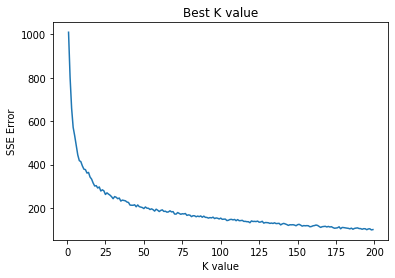

In [50]:
plt.plot(k_rng,sse)
plt.xlabel('K value')
plt.ylabel('SSE Error')
plt.title('Best K value')
# plt.ylim(0,400)
# plt.xlim(0,100)
plt.show()

In [96]:
km = KMeans(n_clusters=6)
predicted_genres = km.fit_predict(song_features)

In [97]:
song_features['predicted_genres'] = predicted_genres
song_features['predicted_genres'] = song_features['predicted_genres'].apply(lambda x: 'Genre'+ str(x))

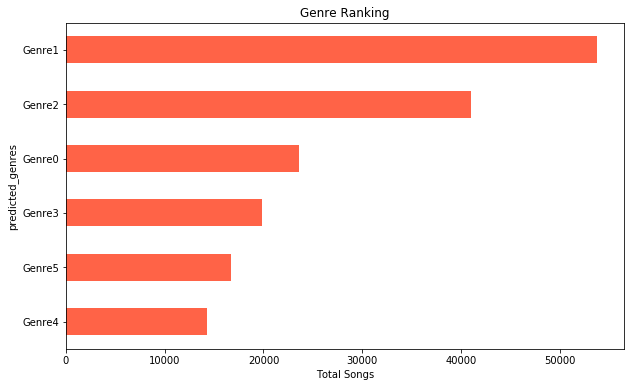

In [98]:
genres_grp = song_features.groupby(['predicted_genres']).size()
# plt.figure(figsize=(10,60))
plt.figure(figsize=(10,6))
genres_grp.sort_values(ascending=True).plot.barh(color='tomato')
plt.xlabel('Total Songs')
plt.title('Genre Ranking')
plt.show()

In [100]:
joblib.dump(km , '../model/km_6.pkl')

['../model/km_6.pkl']

In [112]:
clf = joblib.load('../model//km_20.pkl')

In [115]:
predicted_genres = clf.fit_predict(song_features)
song_features['predicted_genres'] = predicted_genres
song_features['predicted_genres'] = song_features['predicted_genres'].apply(lambda x: 'Genre'+ str(x))

In [116]:
rndperm = np.random.permutation(df.shape[0])

In [117]:
N = 10000
df_subset = song_features.loc[rndperm[:N],:].copy()

In [118]:
data_subset = df_subset.drop(labels='predicted_genres',axis=1).values

In [127]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=10, perplexity=100, n_iter=600)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.079s...
[t-SNE] Computed neighbors for 10000 samples in 1.903s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.233410
[t-SNE] Computed conditional probabilities in 1.350s
[t-SNE] Iteration 50: error = 81.1170044, gradient norm = 0.0220504 (50 iterations in 1.821s)
[t-SNE] I

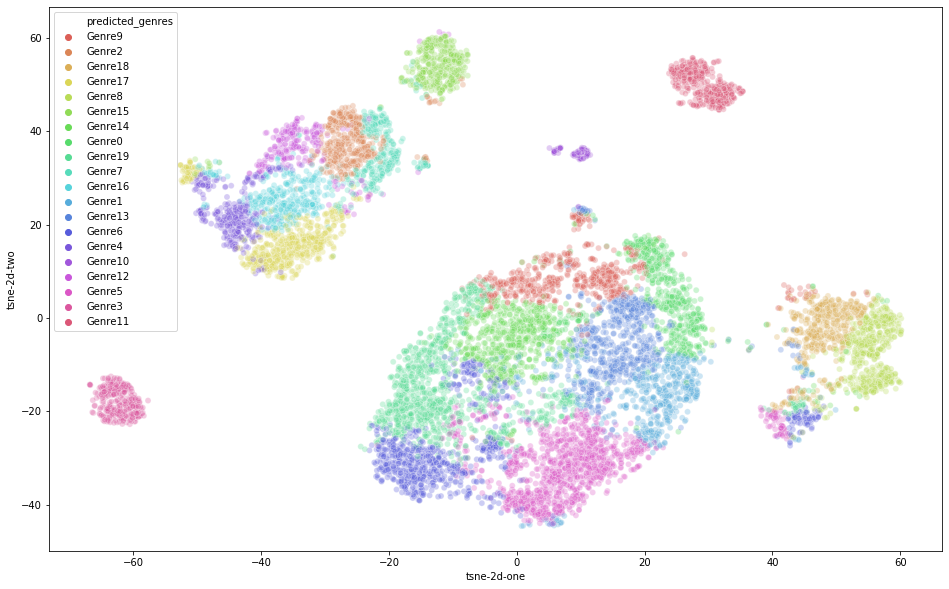

In [126]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="predicted_genres",
    palette=sns.color_palette("hls", 20),
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [132]:
pca_11 = PCA(n_components=11)
pca_result_11 = pca_11.fit_transform(data_subset)

In [133]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=10, perplexity=100, n_iter=600)
tsne_pca_results = tsne.fit_transform(pca_result_11)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.017s...
[t-SNE] Computed neighbors for 10000 samples in 1.619s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.220539
[t-SNE] Computed conditional probabilities in 1.425s
[t-SNE] Iteration 50: error = 83.2077103, gradient norm = 0.0092773 (50 iterations in 1.889s)
[t-SNE] I

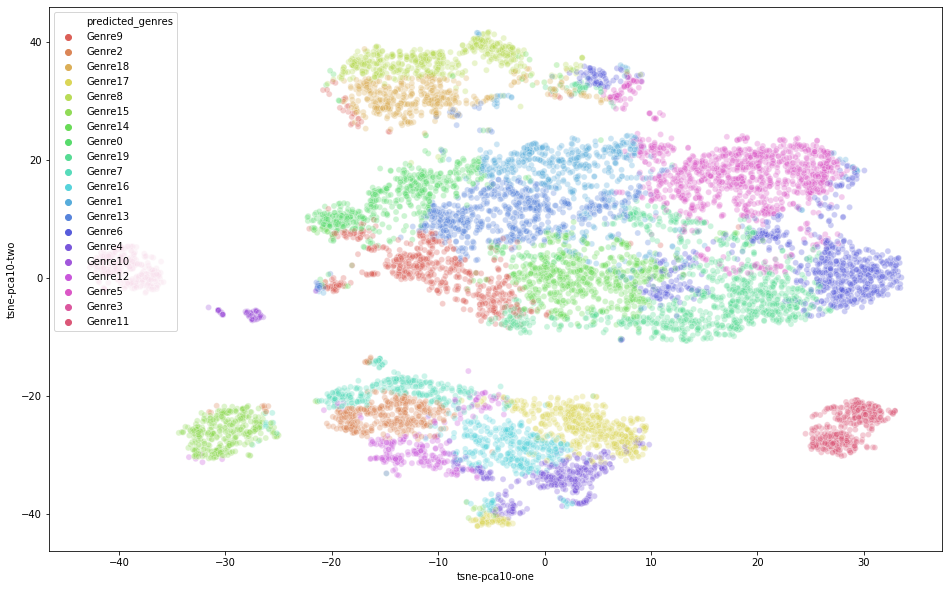

In [134]:
df_subset['tsne-pca10-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca10-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-pca10-one", y="tsne-pca10-two",
    hue="predicted_genres",
    palette=sns.color_palette("hls", 20),
    data=df_subset,
    legend="full",
    alpha=0.3,
)